WHat does this file do?

Load PPTX and TXT files and parse them into a uniform structure.
Chunk by doc type: sentence-based sliding window (transcripts), structural sections (notes), per-slide with sentence sub-chunking when needed (slides); token counts (BART) used to enforce chunk size.
Token-count chunks with the BART tokenizer (for stats and to check the 256 limit).
Embed each chunk with the sentence transformer (MiniLM) → one vector per chunk.
Save chunks.json, embeddings.npy, chunk_metadata.csv.
Stats + plot: table and histogram of chunk token counts by doc type, and warning for chunks over 256 tokens.
Retrieval demo: embed a query, compute cosine similarity to chunk embeddings, return top‑k chunks (and their text).
Reload check: load the saved files and assert they match.

Step 1: Data Loading, Chunking & Embedding

In [ ]:
# !pip install python-pptx transformers sentence-transformers nltk scikit-learn matplotlib

In [ ]:
import os, re, json, warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from typing import List, Dict

# File parsing
from pptx import Presentation                        # pip install python-pptx to read pptx files

# NLP library for text processing
import nltk
# split content into sentences
nltk.download("punkt_tab", quiet=True)
#  turns a paragraph (string) into a list of sentences.
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer

# Embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Chunking Stratergy

1. Split into sentnces 
2. Fill chunks up to the size limit
Add sentences one by one. Use the BART tokenizer to count tokens for each sentence and for the current chunk. When adding the next sentence would push the chunk over 200 tokens, we finish that chunk and start a new one.
3. Overlap by 1 sentence
When we finish a chunk, we keep the last 1 sentence and use it as the start of the next chunk. That way the boundary between chunks isn’t too sharp.
4. Drop tiny chunks
If a chunk has fewer than 30 tokens (e.g. a single short line), we throw it out.

In [ ]:
#  Set Chunking parameters 
CHUNK_SIZE_TOKENS   = 200      # max tokens per chunk
CHUNK_OVERLAP_SENTS = 1       # sentences of overlap between consecutive chunks
MIN_CHUNK_TOKENS    = 30      # discard very short chunks (empty slides, lone headers)

# Models
TOKENIZER_MODEL = "facebook/bart-large-cnn"    
EMBEDDING_MODEL = "all-MiniLM-L6-v2"           
               


DATA_DIR  : C:\Users\som\Desktop\CourseSemII\DeepLearn\slides\Data\StudyLens\data
OUTPUT_DIR: C:\Users\som\Desktop\CourseSemII\DeepLearn\slides\Data\StudyLens\outputs

  File                                                                    Ext      Size
  ────────────────────────────────────────────────────────────────────────────────────
  [slides]_i_nlp.pptx                                                   .PPTX  12356.0 KB
  [slides]_ii_nlp.pptx                                                  .PPTX  21659.1 KB
  Deep Learning Applications _ AIPI 540.01.Sp26 on 2_17_2026 (Tue)_Cap   .TXT   140.6 KB
  Deep Learning Applications _ AIPI 540.01.Sp26 on 2_24_2026 (Tue)_Cap   .TXT   142.9 KB
  nlps2.txt                                                              .TXT    16.8 KB
  notesnlp1.txt                                                          .TXT    10.7 KB


Preview data files

In [ ]:
DATA_DIR   = Path("data/raw")
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)


all_files = sorted(DATA_DIR.iterdir())
print(f"DATA_DIR  : {DATA_DIR.resolve()}")
print(f"OUTPUT_DIR: {OUTPUT_DIR.resolve()}\n")
print(f"  {'File':<68}  {'Ext':>5}  {'Size':>8}")
print("  " + "─" * 84)
for f in all_files:
    print(f"  {f.name[:68]:<68}  {f.suffix.upper():>5}  {f.stat().st_size/1024:>6.1f} KB")

# Data Loading

Load All Files

In [3]:
# Text cleaning helpers 

def clean_transcript(raw: str) -> str:
    """
    Clean auto-generated lecture transcript:
      • Remove [Auto-generated …] header
      • Join short caption fragments into continuous prose
      • Collapse extra whitespace
    """
    lines = raw.splitlines()
    if lines and lines[0].startswith("[Auto-generated"):
        lines = lines[1:]
    text = " ".join(ln.strip() for ln in lines if ln.strip())
    return re.sub(r" {2,}", " ", text).strip()


def clean_notes(raw: str) -> str:
    """
    Light clean for student notes:
      • Normalize line endings
      • Collapse 3+ blank lines → 2
      • Preserve dividers and >>>> adversarial markers (test data!)
    """
    text = raw.replace("\r\n", "\n")
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()


# Loaders 

def load_txt(path: Path) -> Dict:
    raw = path.read_text(encoding="utf-8", errors="replace")
    if "Captions" in path.name:
        doc_type = "transcript"
        text = clean_transcript(raw)
    else:
        doc_type = "notes"
        text = clean_notes(raw)
    return {
        "source":   path.name,
        "doc_type": doc_type,
        "text":     text,
        "metadata": {"path": str(path), "chars": len(text)},
    }


def load_pptx(path: Path) -> Dict:
    """
    Extract text from every slide in a .pptx file.
    Title detected via placeholder_format.idx == 0.
    Returns full-doc text AND a per-slide list for structural chunking.
    """
    prs = Presentation(path)
    slides_data = []

    for slide_num, slide in enumerate(prs.slides, start=1):
        title_text, body_parts = "", []

        for shape in slide.shapes:
            if not shape.has_text_frame:
                continue
            frame = shape.text_frame.text.strip()
            if not frame:
                continue
            try:
                is_title = shape.is_placeholder and shape.placeholder_format.idx == 0
            except AttributeError:
                is_title = False
            if is_title:
                title_text = frame
            else:
                body_parts.append(frame)

        full = "\n".join(filter(None, [title_text] + body_parts)).strip()
        if full:
            slides_data.append({"slide_num": slide_num, "title": title_text, "text": full})

    full_doc = "\n\n--- SLIDE BREAK ---\n\n".join(s["text"] for s in slides_data)
    return {
        "source":   path.name,
        "doc_type": "slides",
        "text":     full_doc,
        "slides":   slides_data,
        "metadata": {"path": str(path), "num_slides": len(slides_data), "chars": len(full_doc)},
    }

In [5]:
# Verify data loading
documents = []

for path in sorted(DATA_DIR.iterdir()):
    ext = path.suffix.lower()
    if ext == ".txt":
        doc = load_txt(path)
        documents.append(doc)
        print(f"  [TXT / {doc['doc_type']:10s}]  {path.name[:58]}  ({doc['metadata']['chars']:>7,} chars)")
    elif ext == ".pptx":
        doc = load_pptx(path)
        documents.append(doc)
        print(f"  [PPTX/ slides    ]  {path.name[:58]}  ({doc['metadata']['num_slides']:>3} slides)")
    else:
        print(f"   [SKIP]  {path.name}")

print(f"\n Loaded {len(documents)} documents total.")

  [PPTX/ slides    ]  [slides]_i_nlp.pptx  (119 slides)
  [PPTX/ slides    ]  [slides]_ii_nlp.pptx  ( 96 slides)
  [TXT / transcript]  Deep Learning Applications _ AIPI 540.01.Sp26 on 2_17_2026  (138,722 chars)
  [TXT / transcript]  Deep Learning Applications _ AIPI 540.01.Sp26 on 2_24_2026  (141,157 chars)
  [TXT / notes     ]  nlps2.txt  ( 16,814 chars)
  [TXT / notes     ]  notesnlp1.txt  ( 10,591 chars)

 Loaded 6 documents total.


In [ ]:
# Verify text loaded
for doc in documents:
    label = (doc['metadata'].get('num_slides') and f"{doc['metadata']['num_slides']} slides") \
            or f"{doc['metadata']['chars']:,} chars"
    print(f"\n{'─'*72}")
    print(f"  source   : {doc['source']}")
    print(f"  doc_type : {doc['doc_type']}   ({label})")
    print(f"  preview  : {doc['text'][:220].replace(chr(10), ' ')} …")


────────────────────────────────────────────────────────────────────────
  source   : [slides]_i_nlp.pptx
  doc_type : slides   (119 slides)
  preview  : Week 6 1 Natural Language Processing I  --- SLIDE BREAK ---  NLP Module This Week:  Introduction, NLP Neural Networks, Implementation  Next Week: NLP Applications, Transformers, Advanced Topics (LLMs) 2  --- SLIDE BREAK  …

────────────────────────────────────────────────────────────────────────
  source   : [slides]_ii_nlp.pptx
  doc_type : slides   (96 slides)
  preview  : Week 7 1 Natural Language Processing II  --- SLIDE BREAK ---  Test corrections can be put in the folder on the front table (test face down)  --- SLIDE BREAK ---  Agenda Attention & Transformers Attention Fundamentals Tra …

────────────────────────────────────────────────────────────────────────
  source   : Deep Learning Applications _ AIPI 540.01.Sp26 on 2_17_2026 (Tue)_Captions_English (United States).txt
  doc_type : transcript   (138,722 chars)
  preview  : 

# Data Chunking

Transcripts: split at sentence endings 
Notes: split at blank spaces/new line
Slides: split at slide boundaries

- NLTK `sent_tokenize` handles abbreviations, decimal points, etc.
- We use the **BART tokenizer** (BPE) to count tokens — not word counts or character counts.  
This guarantees our chunks fit within model limits regardless of vocabulary.

In [ ]:
print(f"Loading tokenizer: {TOKENIZER_MODEL} …")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
print(f" Tokenizer ready. Vocab size: {tokenizer.vocab_size:,}\n")

def count_tokens(text: str) -> int:
    """Count BPE tokens using the BART tokenizer (no special tokens)."""
    return len(tokenizer.encode(text, add_special_tokens=False))

# Sanity check
samples = [
    "Attention is a mechanism that computes a weighted sum of value vectors.",
    "self attn = contextual embeds via dot prod + softmax + weighted sum lol",
    "TF-IDF = TF * log(N / df_t)  where N = total docs, df_t = docs containing term",
]
for s in samples:
    print(f"  {count_tokens(s):>3} tok  |  {s}")

Loading tokenizer: facebook/bart-large-cnn …
✓ Tokenizer ready. Vocab size: 50,265

   15 tok  |  Attention is a mechanism that computes a weighted sum of value vectors.
   17 tok  |  self attn = contextual embeds via dot prod + softmax + weighted sum lol
   29 tok  |  TF-IDF = TF * log(N / df_t)  where N = total docs, df_t = docs containing term


In [ ]:
# ── Strategy 1: Sentence-aware sliding window ─────────────────────────────────
# Best for: transcripts (continuous prose, no natural section markers)
#
# Algorithm:
#   1. Split text into sentences (NLTK)
#   2. Greedily accumulate sentences until adding the next would exceed chunk_size
#   3. Flush chunk; carry last `overlap_sents` sentences into the next chunk
#      (the triggering sentence is re-evaluated — nothing is skipped)
# Edge cases:
#   • Single sentence > chunk_size  → emitted as-is (can't split mid-sentence)
#   • Overlap alone   > chunk_size  → overlap discarded, fresh start

def chunk_by_sentences(
    text: str,
    chunk_size: int = CHUNK_SIZE_TOKENS,
    overlap_sents: int = CHUNK_OVERLAP_SENTS,
    min_tokens: int = MIN_CHUNK_TOKENS,
) -> List[str]:
    sentences = sent_tokenize(text)
    if not sentences:
        text_stripped = text.strip()
        if text_stripped and count_tokens(text_stripped) >= min_tokens:
            return [text_stripped]
        return []

    chunks: List[str] = []
    cur_sents: List[str] = []
    cur_tokens: int = 0
    i = 0

    while i < len(sentences):
        sent = sentences[i]
        sent_tok = count_tokens(sent)

        # Edge case: single sentence exceeds limit — emit as its own chunk
        if sent_tok > chunk_size and not cur_sents:
            chunks.append(sent)
            i += 1
            continue

        # Adding this sentence would overflow → flush current chunk
        if cur_tokens + sent_tok > chunk_size and cur_sents:
            chunk_text = " ".join(cur_sents)
            if count_tokens(chunk_text) >= min_tokens:
                chunks.append(chunk_text)

            # Overlap: carry last N sentences into next chunk
            if overlap_sents and len(cur_sents) > overlap_sents:
                ov = cur_sents[-overlap_sents:]
                ov_tok = sum(count_tokens(s) for s in ov)
                if ov_tok < chunk_size:       # overlap must itself fit
                    cur_sents, cur_tokens = ov, ov_tok
                else:
                    cur_sents, cur_tokens = [], 0
            else:
                cur_sents, cur_tokens = [], 0
            continue   # ← i NOT incremented: re-evaluate current sentence in new chunk

        cur_sents.append(sent)
        cur_tokens += sent_tok
        i += 1

    # Flush remainder
    if cur_sents:
        chunk_text = " ".join(cur_sents)
        if count_tokens(chunk_text) >= min_tokens:
            chunks.append(chunk_text)

    return chunks


# Quick test (min_tokens=10 so the small test chunks are not discarded)
test_para = """The attention mechanism computes a weighted sum of value vectors.
Each word attends to every other word in the sequence via dot-product scores.
Scores are normalized through a softmax function to produce attention weights.
These weights are NOT trainable — only the key, query, and value matrices are."""

test_chunks = chunk_by_sentences(test_para, chunk_size=30, min_tokens=10)
print(f"Test: {len(test_chunks)} chunks from {count_tokens(test_para)}-token paragraph")
for i, c in enumerate(test_chunks):
    print(f"  chunk {i}: {count_tokens(c):>3} tok | {c[:80]} ...")

In [ ]:
# ── Strategy 2: Blank-line block merging ──────────────────────────────────────
# Best for: student notes (topic boundaries at blank lines)
# Fallback: if a block > chunk_size, sub-chunk via sentence sliding window

_BLANK_LINE_RE = re.compile(r"\n\s*\n")

def chunk_by_structure(
    text: str,
    chunk_size: int = CHUNK_SIZE_TOKENS,
    min_tokens: int = MIN_CHUNK_TOKENS,
) -> List[str]:
    """Split notes at blank lines, greedily merge short adjacent blocks."""
    blocks = _BLANK_LINE_RE.split(text)
    chunks: List[str] = []
    buf_text, buf_tokens = "", 0

    for block in blocks:
        block = block.strip()
        if not block:
            continue
        block_tok = count_tokens(block)

        if block_tok > chunk_size:
            if buf_text and buf_tokens >= min_tokens:
                chunks.append(buf_text.strip())
                buf_text, buf_tokens = "", 0
            chunks.extend(chunk_by_sentences(block, chunk_size, min_tokens=min_tokens))
            continue

        if buf_tokens + block_tok > chunk_size and buf_text:
            if buf_tokens >= min_tokens:
                chunks.append(buf_text.strip())
            buf_text, buf_tokens = block, block_tok
        else:
            buf_text = (buf_text + "\n\n" + block).strip()
            buf_tokens += block_tok

    if buf_text and buf_tokens >= min_tokens:
        chunks.append(buf_text.strip())

    return chunks


print("chunk_by_structure defined (blank-line merge)")

**Interpretation:** The table summarises chunk counts and token statistics per document type (transcript, notes, slides) and flags any chunks over the 200-token target or the 256-token embedding limit. The left plot shows the overall distribution of chunk sizes with the target and limit lines; the right plot shows the same by document type so you can see which sources tend to produce longer chunks.

In [ ]:
# ── Strategy 3: Per-slide ─────────────────────────────────────────────────────
# Best for: PPTX slides (each slide = self-contained semantic unit)
# Short adjacent slides are merged into one chunk to avoid tiny chunks.
# Unusually long slides (dense bullet content) are sub-chunked via sentence sliding window.

def chunk_by_slides(
    slides: List[Dict],
    chunk_size: int = CHUNK_SIZE_TOKENS,
    min_tokens: int = MIN_CHUNK_TOKENS,
) -> List[str]:
    chunks: List[str] = []
    buf_text, buf_tokens = "", 0

    for slide in slides:
        slide_text = slide["text"]
        slide_tok  = count_tokens(slide_text)

        if slide_tok > chunk_size:
            # Flush buffer, then sub-chunk this long slide
            if buf_text and buf_tokens >= min_tokens:
                chunks.append(buf_text.strip())
            chunks.extend(chunk_by_sentences(slide_text, chunk_size, min_tokens=min_tokens))
            buf_text, buf_tokens = "", 0
            continue

        if buf_tokens + slide_tok > chunk_size and buf_text:
            # Buffer full → flush, start new buffer with this slide
            if buf_tokens >= min_tokens:
                chunks.append(buf_text.strip())
            buf_text, buf_tokens = slide_text, slide_tok
        else:
            # Merge slide into buffer
            buf_text   = (buf_text + "\n\n" + slide_text).strip()
            buf_tokens += slide_tok

    if buf_text and buf_tokens >= min_tokens:
        chunks.append(buf_text.strip())

    return chunks


print("chunk_by_slides defined ")

chunk_by_slides defined ✓


In [ ]:
# ── Apply chunking to all documents ───────────────────────────────────────────
STRATEGY_MAP = {
    "transcript": ("sentence_sliding_window", lambda doc: chunk_by_sentences(doc["text"])),
    "notes":      ("blank_line_merge",        lambda doc: chunk_by_structure(doc["text"])),
    "slides":     ("per_slide",               lambda doc: chunk_by_slides(doc["slides"])),
}

all_chunks: List[Dict] = []
seen_stems: Dict[str, int] = {}

print(f"  {'Source':<52}  {'Type':12}  {'#Chunks':>7}  Strategy")
print("  " + "─" * 96)

for doc in documents:
    strategy_name, chunker_fn = STRATEGY_MAP[doc["doc_type"]]
    raw_chunks = chunker_fn(doc)

    stem = Path(doc["source"]).stem[:20]
    if stem in seen_stems:
        seen_stems[stem] += 1
        stem = f"{stem}_{seen_stems[stem]}"
    else:
        seen_stems[stem] = 0

    for idx, chunk_text in enumerate(raw_chunks):
        all_chunks.append({
            "chunk_id":    f"{stem}__c{idx:03d}",
            "source":      doc["source"],
            "doc_type":    doc["doc_type"],
            "chunk_index": idx,
            "strategy":    strategy_name,
            "text":        chunk_text,
            "token_count": count_tokens(chunk_text),
        })

    print(f"  {doc['source'][:50]:<50}  {doc['doc_type']:12}  {len(raw_chunks):>7}  {strategy_name}")

print(f"\n  {'─'*96}")
print(f"  Total chunks: {len(all_chunks)}")

=== Token count statistics by document type ===

            n_chunks   mean  median  min  max  over_200  over_256
doc_type                                                         
notes             52  191.1   162.0   37  665        13         7
slides            92  170.5   169.0   47  388         9         3
transcript       371  189.7   193.0   59  200         0         0

⚠  10 chunk(s) exceed MiniLM's 256-token limit (will be truncated):
             chunk_id doc_type  token_count
 [slides]_i_nlp__c011   slides          388
 [slides]_i_nlp__c017   slides          376
[slides]_ii_nlp__c039   slides          348
          nlps2__c001    notes          435
          nlps2__c005    notes          339
          nlps2__c008    notes          665
          nlps2__c009    notes          369
          nlps2__c032    notes          376
      notesnlp1__c006    notes          524
      notesnlp1__c015    notes          302


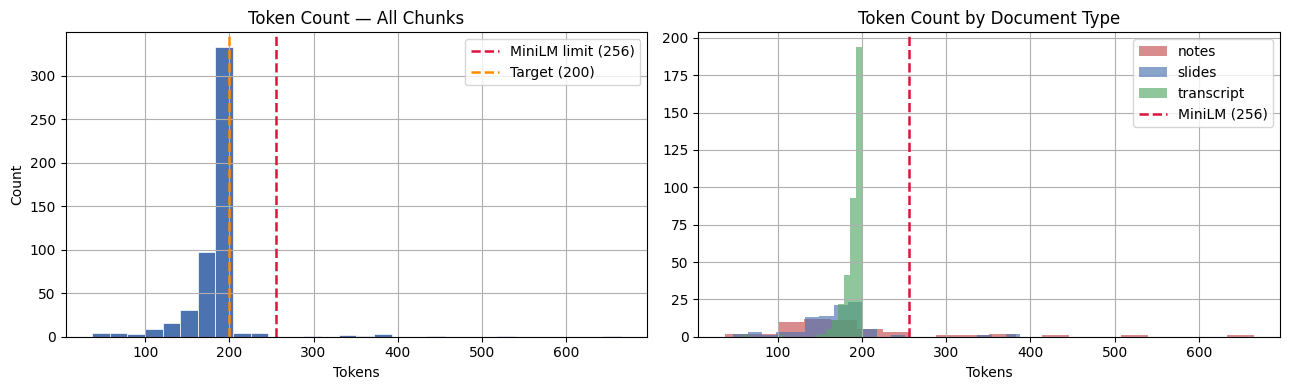

✓ Saved → outputs\chunk_distribution.png


In [ ]:
# ── Chunk statistics + distribution plot ──────────────────────────────────────
df = pd.DataFrame(all_chunks)

print("=== Token count statistics by document type ===\n")
stats = (
    df.groupby("doc_type")["token_count"]
    .agg(
        n_chunks="count",
        mean="mean",
        median="median",
        min="min",
        max="max",
        over_200=lambda x: (x > 200).sum(),
        over_256=lambda x: (x > 256).sum(),   # MiniLM hard limit
    )
    .round(1)
)
print(stats.to_string())

# Flag any chunks that exceed MiniLM's limit
over_256 = df[df["token_count"] > 256]
if len(over_256):
    print(f"\n  {len(over_256)} chunk(s) exceed MiniLM's 256-token limit (will be truncated):")
    print(over_256[["chunk_id", "doc_type", "token_count"]].to_string(index=False))
else:
    print(f"\n  All {len(df)} chunks fit within MiniLM's 256-token embedding limit.")

# ── Plot ──────────────────────────────────────────────────────────────────────
palette = {"transcript": "#55a868", "notes": "#c44e52", "slides": "#4c72b0"}
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: overall distribution
df["token_count"].hist(bins=30, ax=axes[0], color="#4C72B0", edgecolor="white", linewidth=0.5)
axes[0].axvline(256, color="crimson",    linestyle="--", linewidth=1.8, label="MiniLM limit (256)")
axes[0].axvline(200, color="darkorange", linestyle="--", linewidth=1.8, label=f"Target ({CHUNK_SIZE_TOKENS})")
axes[0].set_title("Token Count — All Chunks", fontsize=12)
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Count")
axes[0].legend()

# Right: by doc type
for dtype, grp in df.groupby("doc_type"):
    grp["token_count"].hist(bins=20, ax=axes[1], alpha=0.65,
                             color=palette.get(dtype, "gray"), label=dtype)
axes[1].axvline(256, color="crimson", linestyle="--", linewidth=1.8, label="MiniLM (256)")
axes[1].set_title("Token Count by Document Type", fontsize=12)
axes[1].set_xlabel("Tokens")
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "chunk_distribution.png", dpi=130, bbox_inches="tight")
plt.show()
print(f" Saved {OUTPUT_DIR / 'chunk_distribution.png'}")

The left histogram is the overall chunk-size distribution with the target and limit lines; the right one is the same by document type so you can see which sources (e.g. notes/slides) produce longer chunks. The notes have 7 chunks and slides have 3 chunks Over 256-token limit. These will be truncated.

In [ ]:
# ── Inspect sample chunks per type ────────────────────────────────────────────
for dtype in df["doc_type"].unique():
    sample = df[df["doc_type"] == dtype].iloc[0]

    print(f"  doc_type : {dtype}")
    print(f"  chunk_id : {sample['chunk_id']}")
    print(f"  tokens   : {sample['token_count']}")
    print(f"  strategy : {sample['strategy']}")
    print(f"  text     :\n{sample['text'][:400]}")
    print("  …")


══════════════════════════════════════════════════════════════════════
  doc_type : slides
  chunk_id : [slides]_i_nlp__c000
  tokens   : 135
  strategy : per_slide
  text     :
Week 6
1
Natural Language Processing I

NLP Module
This Week: 
Introduction, NLP Neural Networks, Implementation

Next Week:
NLP Applications, Transformers, Advanced Topics (LLMs)
2

Agenda
Introduction to Natural Language Processing
Tasks, Challenges, & Applications
Text Preprocessing
Traditional Approaches

NLP Neural Networks
Word Embeddings (Word2Vec)
Recurrent Neural Networks
LSTM and GRU arc
  …

══════════════════════════════════════════════════════════════════════
  doc_type : transcript
  chunk_id : Deep Learning Applic__c000
  tokens   : 200
  strategy : sentence_sliding_window
  text     :
Like there's always me. And the grades are terrible. Are you. Are you serious? You can be great. Oh, they are, and I'm scared. I'm trying. How are you? I'm trying to. I have to be pretty. I put them in canvas as c

# Dense Embeddings

Model: `all-MiniLM-L6-v2`

| Property | Value |
|---|---|
| Dimensions | 384|
| Max input tokens | 256 |
| Parameters | ~22M |
| Speed vs mpnet | ~5× faster |
| Training | 1B+ sentence pairs (MS-MARCO, NLI, etc.) |

Why this model?
- Our 200-token chunks sit comfortably within the 256-token limit (no truncation)
- 384-dim vectors fit in memory — no FAISS needed for this dataset size
- `normalize_embeddings=True` → L2-normalised vectors → cosine similarity = dot product (faster retrieval)


In [16]:
print(f"Loading embedding model: {EMBEDDING_MODEL} …")
embed_model = SentenceTransformer(EMBEDDING_MODEL)

print(f" Model loaded")
print(f"  Max sequence length : {embed_model.max_seq_length} tokens")
print(f"  Embedding dimension : {embed_model.get_sentence_embedding_dimension()}")

chunk_texts = [c["text"] for c in all_chunks]
print(f"\nEmbedding {len(chunk_texts)} chunks …")

embeddings = embed_model.encode(
    chunk_texts,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True,    # L2-normalise → cosine sim = dot product
    convert_to_numpy=True,
)

print(f"\n Embeddings: {embeddings.shape}   ({embeddings.shape[0]} chunks × {embeddings.shape[1]} dims)")
print(f"  dtype  : {embeddings.dtype}")
print(f"  norm[0]: {np.linalg.norm(embeddings[0]):.5f}   (≈ 1.0 after L2 normalisation)")

Loading embedding model: all-MiniLM-L6-v2 …
 Model loaded
  Max sequence length : 256 tokens
  Embedding dimension : 384

Embedding 515 chunks …


Batches:   0%|          | 0/17 [00:00<?, ?it/s]


 Embeddings: (515, 384)   (515 chunks × 384 dims)
  dtype  : float32
  norm[0]: 1.00000   (≈ 1.0 after L2 normalisation)


Verify for our 2 topics :  "Neural Networks for NLP",    "Attention & Transformers" (Embed query)
 and return top-k most similar chunks via cosine similarity

In [18]:
# ── Sanity-check: semantic retrieval demo ─────────────────────────────────────
# If the embeddings are working correctly, topic-matched chunks should rank first.

def retrieve(query: str, top_k: int = 3) -> pd.DataFrame:
    """Embed query and return top-k most similar chunks via cosine similarity."""
    q_vec  = embed_model.encode([query], normalize_embeddings=True)
    scores = cosine_similarity(q_vec, embeddings)[0]
    top_idx = np.argsort(scores)[::-1][:top_k]
    return pd.DataFrame([{
        "rank":     r + 1,
        "score":    round(float(scores[i]), 4),
        "doc_type": all_chunks[i]["doc_type"],
        "source":   Path(all_chunks[i]["source"]).name[:38],
        "preview":  all_chunks[i]["text"][:100].replace("\n", " ") + "…",
    } for r, i in enumerate(top_idx)])


test_queries = [
    "Neural Networks for NLP: word embeddings word2vec GloVe RNN LSTM GRU sequence models",
    "Attention & Transformers: self-attention keys queries values multi-head transformer BERT GPT",
   # "self-attention mechanism and how it produces contextual embeddings",
    #"text preprocessing steps: tokenization stemming lemmatization",
    #"ROUGE metric for evaluating summarization quality",
    #"BERT vs GPT architecture differences",
]

for q in test_queries:

    print(f"  QUERY: {q}")
    print(retrieve(q).to_string(index=False))

  QUERY: Neural Networks for NLP: word embeddings word2vec GloVe RNN LSTM GRU sequence models
 rank  score doc_type              source                                                                                               preview
    1 0.6285   slides [slides]_i_nlp.pptx GloVe (Global Vectors for Word Representation)  👉 Word2Vec = prediction-based👉 GloVe = count-based …
    2 0.5786   slides [slides]_i_nlp.pptx 59 Word2Vec Two training methods: Skip-gram: Predict context words given center word Better for rare…
    3 0.5592   slides [slides]_i_nlp.pptx Averaging Word2Vec embeddings weakens document representation because it ignores word order and trea…
  QUERY: Attention & Transformers: self-attention keys queries values multi-head transformer BERT GPT
 rank  score   doc_type                                 source                                                                                               preview
    1 0.6283      notes                              nlps2.txt 

Save Outputs

| File | Format | Contents |
|------|--------|----------|
| `chunks.json` | JSON | All chunk dicts — text + metadata (no embeddings) |
| `embeddings.npy` | NumPy | Float32 matrix `(n_chunks, 384)` — row `i` = embedding for `chunks[i]` |
| `chunk_metadata.csv` | CSV | Chunk stats for quick inspection |

**Loading in the next step:**
```python
chunks     = json.load(open("outputs/chunks.json"))
embeddings = np.load("outputs/embeddings.npy")
```

In [21]:
# 1. chunks.json  (text + metadata, no embedding arrays)
chunks_path = OUTPUT_DIR / "chunks.json"
with open(chunks_path, "w", encoding="utf-8") as f:
    json.dump(all_chunks, f, indent=2, ensure_ascii=False)
print(f" chunks.json : {chunks_path}")

# 2. embeddings.npy  (float32, L2-normalised)
embed_path = OUTPUT_DIR / "embeddings.npy"
np.save(embed_path, embeddings)
print(f" embeddings.npy : {embed_path}   shape={embeddings.shape}")

# 3. chunk_metadata.csv
csv_path = OUTPUT_DIR / "chunk_metadata.csv"
df.to_csv(csv_path, index=False)
print(f" chunk_metadata.csv : {csv_path}")

# 4. Reload verification
loaded_chunks = json.load(open(chunks_path, encoding="utf-8"))
loaded_embeds = np.load(embed_path)
assert len(loaded_chunks) == len(loaded_embeds), "Length mismatch!"
assert loaded_embeds.shape[1] == 384, "Wrong embedding dim!"
print(f"\n Reload check passed: {len(loaded_chunks)} chunks, embeddings {loaded_embeds.shape}")

print(f"""

  Documents loaded      : {len(documents):<35}
  Total chunks          : {len(all_chunks):<35}
  Chunks > 256 tok      : {int((df['token_count'] > 256).sum()):<35}
  Embedding shape       : {str(embeddings.shape):<35}
  Embedding model       : {EMBEDDING_MODEL:<35}
  Outputs saved to      : outputs/      """)                      


 chunks.json : outputs\chunks.json
 embeddings.npy : outputs\embeddings.npy   shape=(515, 384)
 chunk_metadata.csv : outputs\chunk_metadata.csv

 Reload check passed: 515 chunks, embeddings (515, 384)


  Documents loaded      : 6                                  
  Total chunks          : 515                                
  Chunks > 256 tok      : 10                                 
  Embedding shape       : (515, 384)                         
  Embedding model       : all-MiniLM-L6-v2                   
  Outputs saved to      : outputs/      
